<a href="https://colab.research.google.com/github/kento-koyama/bayesian_predictive_micro_ICPMF12/blob/main/Example_2/2-2%20Workshop_(growth).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table class="tfo-notebook-buttons" align="left">
<td>
<a target="_blank" href="https://github.com/kento-koyama/bayesian_predictive_micro_ICPMF12/"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td>
</table>

#Fitting of Bayesian model
##Installation and Loading libraries.  
>**pystan**: Bayesian MCMC  
>**nest_asyncio**: Library for stan in notebook.  
>**pandas**: Data manipulation  
> **numpy**: Data calculation  
>**seaborn**: Visualization  
>**matplotlib.pyplot**: Visualization  
>**arviz**: Visualization of pystan  
   
- The softwares will be installed in the temporary cloud computer.  
- **Nothing will be installed in your own PC**. 
- It must be installed at the very beginning of every calculation.   
- The installation could take a little time.

In [1]:
# Installation
!pip install pystan
!pip install nest_asyncio
# Importing
import nest_asyncio
nest_asyncio.apply()
import stan 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import math
import arviz as az
from sklearn.metrics import mean_squared_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 1.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Data reading and preperation

The data imported from reported article through github: [Hiura, S., Abe, H., Koyama, K. & Koseki, S. Bayesian generalized linear model for simulating bacterial inactivation/growth considering variability and uncertainty. Front. Microbiol. 12, 674364 (2021)](https://doi.org/10.3389/fmicb.2021.674364).

In [2]:
#import data 
url = "https://raw.githubusercontent.com/Satoko-Hiura/Bayesian-generalized-linear-model-for-simulating-bacterial-inactivation-growth/main/code/growth/data/bayesian_fitting.csv"
data = pd.read_csv(url, encoding='utf-8')
TIME = data['TIME']
N = data['Nt']
N_new = N *(10 ** data['Dilution'])
data['N_new'] = N_new
N_new = data['N_new']
N0_objective = data['N0_objective']
Initial = data['Initial']

In [3]:
data

,TIME,Nt,Dilution,N0_objective,Initial,N_new
0,0,65,2,10000,1,6500
1,0,56,2,10000,2,5600
2,0,64,2,10000,3,6400
3,2,79,2,10000,0,7900
4,2,61,2,10000,0,6100
5,2,76,2,10000,0,7600
6,4,222,2,10000,0,22200
7,4,235,2,10000,0,23500
8,4,218,2,10000,0,21800
9,6,84,3,10000,0,84000


##Model construction
- The `stan_code` include a the *script* for stan (C language).  
- The stan script is constructed by several sections.

###Data section
Definition of the input data shape  

    data {
      int K;
      array[K] real TIME;
      array[K] int N_new;
      array[K] real N0_objective;
      array[K] int Initial; 
    }

###Transformed data section
Changing the expression of the data  
Seting of a threshold （N0） in bacteria number

    transformed data{
  	array[K] int N0;
	  for (k in 1:K) {
		  N0[k] = poisson_rng(N0_objective[k]); 	
	  }
    }

###Parameters section
Setting of the parameters  

    parameters {
      real mu;
      real lag;
      real n0;
    }
###Transformed parameters section
Changing expression and define the prediction   
Equation from the lag-linear model:


\begin{cases}
  log_{10}N_{(t)pred} = log_{10}N_{0} & (t \leq lag) \\\
  log_{10}N_{(t)pred} = log_{10}N_{0}\times exp(\mu \times (t-\lambda))& (t > lag)
\end{cases}
  
  The negative binomial distribution $Negbin(N_{0},p)$, describing the growth amount (CFU), needs the probability as for the stochastic calculation.

\begin{equation} 
  p_{(t)}= \frac{N_{0}}{N_{(t)pred}} \space\space\space\space (t > lag)
\end{equation}
    
    transformed parameters {
      array[K] real p;
      for (k in 1:K) {
          p[k] = exp((-mu) * (TIME[k]-lag));
		  if (TIME[k] <= lag) {
			  p[k] = 0;
		  }
		  else {
			  p[k] = exp((-mu) * (TIME[k]-lag));
		  }
	  }
    }
###Model section
Definition of prior distributions  \

 $N_{(0)} 	\sim Poisson(N_{0})$    
 $N_{(t)} 	\sim NegBin(N_{0}, p_{(t)})$ 

    model {
	  for (k in 1:K) {
		  if (Initial[k] != 0) {
			  N_new[Initial[k]] ~ poisson(n0);
		  }
		  if (Initial[k] == 0 ) {
			  if ( N_new[k] >= N0[k] ) {
				  (N_new[k]-N0[k]) ~ neg_binomial(n0, p[k]) ; 
			  }
			  else {
				  N_new[k] ~ poisson(n0);
			  }	
		  }
	  }
    }

In [4]:
#parameter estimation
#compile

stan_code = """
  data {
    int K;
    array[K] real TIME;
    array[K] int N_new;
    array[K] real N0_objective;
    array[K] int Initial; 
  }

  transformed data{
  	array[K] int N0;
	  for (k in 1:K) {
		  N0[k] = poisson_rng(N0_objective[k]); 	
	  }
  }

  parameters {
    real mu;
    real lag;
    real n0;
  }

  transformed parameters {
      array[K] real p;
      for (k in 1:K) {
          p[k] = exp((-mu) * (TIME[k]-lag));
		  if (TIME[k] <= lag) {
			  p[k] = 0;
		  }
		  else {
			  p[k] = exp((-mu) * (TIME[k]-lag));
		  }
	  }
  }

  model {
	  for (k in 1:K) {
		  if (Initial[k] != 0) {
			  N_new[Initial[k]] ~ poisson(n0);
		  }
		  if (Initial[k] == 0 ) {
			  if ( N_new[k] >= N0[k] ) {
				  (N_new[k]-N0[k]) ~ neg_binomial(n0, p[k]) ; 
			  }
			  else {
				  N_new[k] ~ poisson(n0);
			  }	
		  }
	  }
  }
"""



###Setting of dataset for stan

In [5]:
stan_data = data.to_dict('list')
stan_data.update({'K':len(data)})

##Building the MCMC calculation frame including the dataset. 
- It could take a little time.

In [6]:
posterior = stan.build(stan_code, data=stan_data)

Building...



Building: 43.2s, done.Messages from stanc:
Warning in '/tmp/httpstan_gd15snym/model_z7knvoff.stan', line 46, column 25: A
    poisson distribution is given parameter n0 as a rate parameter (argument
    1), but n0 was not constrained to be strictly positive.
Warning in '/tmp/httpstan_gd15snym/model_z7knvoff.stan', line 43, column 38: A
    neg_binomial distribution is given parameter n0 as a shape parameter
    (argument 1), but n0 was not constrained to be strictly positive.
Warning in '/tmp/httpstan_gd15snym/model_z7knvoff.stan', line 39, column 33: A
    poisson distribution is given parameter n0 as a rate parameter (argument
    1), but n0 was not constrained to be strictly positive.
Warning in '/tmp/httpstan_gd15snym/model_z7knvoff.stan', line 27, column 4: A
    control flow statement depends on parameter(s): lag.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In

##Bayesian inference using MCMC through Stan

In [7]:
#MCMC sampling
fit_nuts = posterior.sample(num_samples=2500, num_chains=4, num_warmup = 5000)

Sampling:   0%
Sampling:   2% (700/30000)
Sampling:   6% (1700/30000)
Sampling:  10% (3000/30000)
Sampling:  14% (4100/30000)
Sampling:  18% (5400/30000)
Sampling:  22% (6700/30000)
Sampling:  28% (8300/30000)
Sampling:  41% (12400/30000)
Sampling:  52% (15500/30000)
Sampling:  53% (16000/30000)
Sampling:  62% (18600/30000)
Sampling:  64% (19300/30000)
Sampling:  66% (19700/30000)
Sampling:  68% (20400/30000)
Sampling:  70% (20900/30000)
Sampling:  80% (23900/30000)
Sampling:  89% (26600/30000)
Sampling:  90% (27100/30000)
Sampling:  96% (28900/30000)
Sampling: 100% (30000/30000)
Sampling: 100% (30000/30000), done.
Messages received during sampling:
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: neg_binomial_lpmf: Inverse scale parameter is 0, but 

###Summary of the Bayesian MCMC inference.    
You can check the parameters and the transformed parameters of
- **mean**: Mean
- **sd**: Standad deviation
- **hdi_3%**: 3% point
- **hdi_97%**: 97% point
- **mcse_mean**: Monte Carlo standard error for the mean
- **mcse_sd**: Monte Carlo standard error for the standard deviation
- **ess_bulk**: Bulk effective sample size
- **ess_tail**: the tail effective sample size
- **r_hat**: Rhat convergence diagnostic
  - We can check the convergence of the posteriors with an Rhat value of 1.0 or less than 1.1.

In [8]:
az.summary(fit_nuts)

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.714,0.001,0.712,0.715,0.00,0.000,4583.0,4868.0,1.0
lag,2.718,0.011,2.697,2.738,0.00,0.000,3286.0,4133.0,1.0
n0,6354.381,31.405,6293.903,6411.375,0.52,0.368,3642.0,4231.0,1.0
p[0],0.000,0.000,0.000,0.000,0.00,0.000,10000.0,10000.0,NaN
p[1],0.000,0.000,0.000,0.000,0.00,0.000,10000.0,10000.0,NaN
p[2],0.000,0.000,0.000,0.000,0.00,0.000,10000.0,10000.0,NaN
p[3],0.000,0.000,0.000,0.000,0.00,0.000,10000.0,10000.0,NaN
p[4],0.000,0.000,0.000,0.000,0.00,0.000,10000.0,10000.0,NaN
p[5],0.000,0.000,0.000,0.000,0.00,0.000,10000.0,10000.0,NaN
p[6],0.400,0.003,0.395,0.406,0.00,0.000,3241.0,4196.0,1.0


###Traceplot of the estimated parameters
- It includes the transformed parameters
- We can visually check the convergence of the posteriors and unusual convergences through graphical analysis.

/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


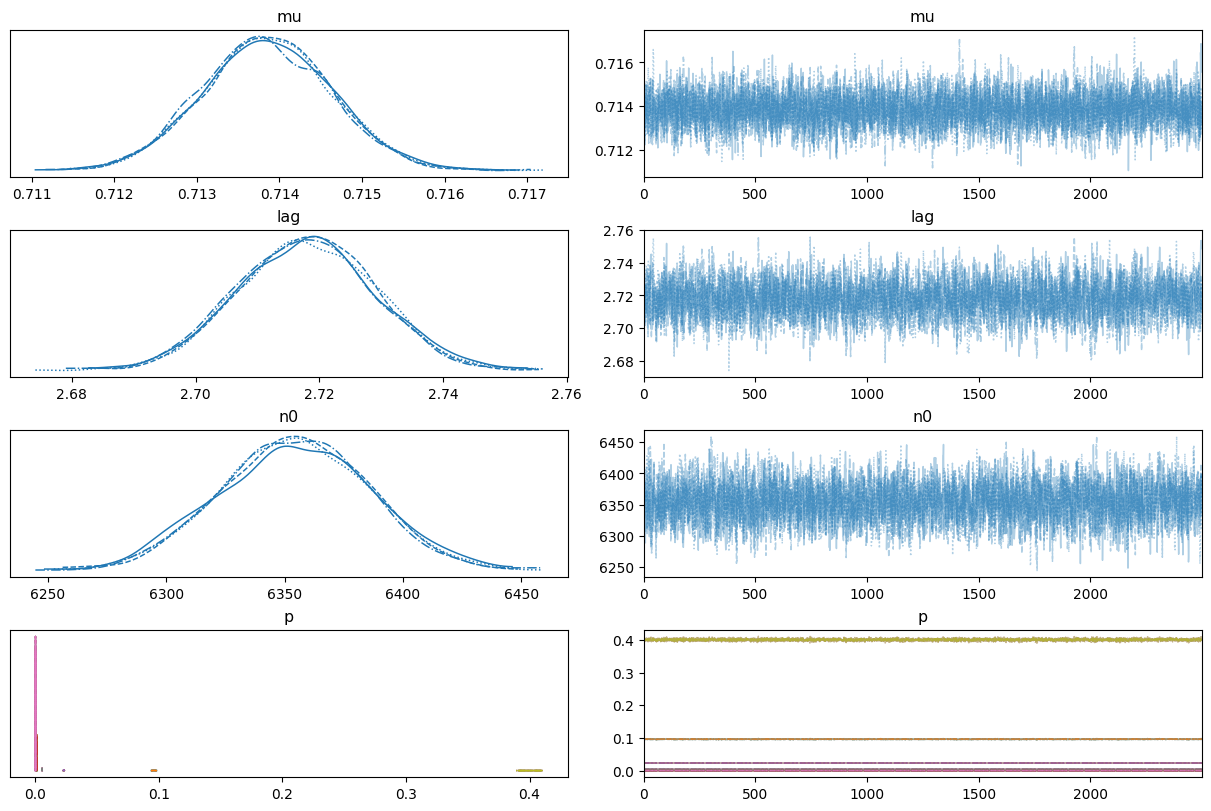

In [9]:
az.plot_trace(fit_nuts, backend_kwargs={"constrained_layout":True}, combined=False)
plt.show()

###Extraction of the posteriors

In [10]:
mu = fit_nuts['mu'][0,:].T #scale parameter(δ)
lag = fit_nuts['lag'][0,:].T #shape parameter(p)

##Parameter matrix of the estimated Bayesian model
Definition of the parameters correlation function (Spearman)

In [11]:
#correlation
def corrfunc(x, y, **kws):
    r, _ = stats.spearmanr(x, y)
    ax = plt.gca()
    ax.axis('on')
    txtcolor = 'black' if math.fabs(r) < 0.5 else 'white'
    ax.text(.5, .5, 'Corr:\n{:.2f}'.format(r),color=txtcolor, fontsize=28, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

Visualisation of parameter matrix and correlations and parameter distribution

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:181: UserWarning: The label '_nolegend_' of <matplotlib.patches.Patch object at 0x7f04c0eb2ce0> starts with '_'. It is thus excluded from the legend.
  figlegend = self._figure.legend(handles, labels, **kwargs)


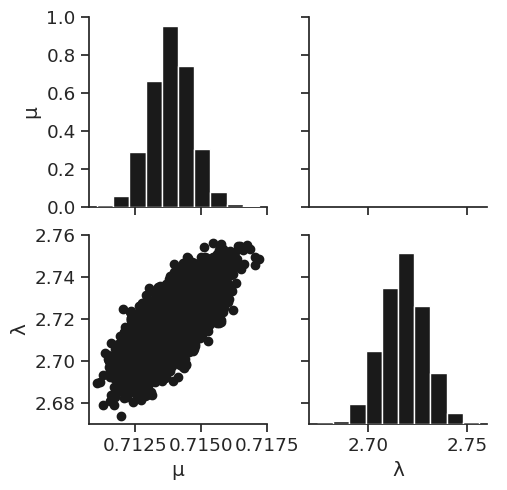

In [12]:
#pairplot
sns.set(style='ticks', font_scale=1.2)
d = pd.DataFrame({'µ':mu, 'λ':lag},columns=['µ', 'λ'])
g = sns.PairGrid(d)
g = g.map_diag(plt.hist,color='k')
g = g.map_lower(plt.scatter,color='k')
g = g.map_upper(corrfunc)
g = g.add_legend()

#Comparison of the kinetic & Bayesian Weibull model   
##Estimation of the kinetic model. 
Data import

In [13]:
#data load (frequentism)
url = "https://raw.githubusercontent.com/Satoko-Hiura/Bayesian-generalized-linear-model-for-simulating-bacterial-inactivation-growth/main/code/growth/data/frequentism_fitting.csv"
data = pd.read_csv(url, encoding='utf-8')

t = data['TIME']
N = data['Nt']
N0 = N[0]



Kinetically fitting of the Weibull model
- The parameters would be determined as one value.

In [14]:
#fitting (frequentism)
parameter_initial = np.array([0.8,1.2])
def func(t,mu, lag):
    N = N0 + (0*(t<=lag) + np.log10(np.exp(mu*(t-lag)))*(t>lag))
    return N
parameter_optimal, covariance= scipy.optimize.curve_fit(func, t, N, p0=parameter_initial)
print("mu =", format(parameter_optimal[0]))
print("lag =", format(parameter_optimal[1]))

#prediction of fitting (frequentism)
T = np.arange(0,18.05,0.05)
Y = func(T,parameter_optimal[0],parameter_optimal[1])

#calculate RMSE
T1 = np.arange(0,18,2)
Y1 = []
for j in range(len(T1)):
    y1 = Y[T1[j]*20]
    Y1.append(y1)
RMSE = np.sqrt(mean_squared_error(Y1,N))
print("RMSE= ", format(RMSE))

mu = 0.6793805117000169
lag = 2.17500556734342
RMSE=  0.04581597288412527


Kinetically prediction of the Weibull model.

Extraction of posteriors

In [15]:
#fitting by bayesian 
mu = fit_nuts['mu'][0,:].T #scale parameter(δ)
lag = fit_nuts['lag'][0,:].T #shape parameter(p)
N0_mean = 6167



###Estimation from the estimated Bayesian model
**Credible interval**: The variated interval of the estimated curve lines  
**Prediction interval**: The variated interval of the estimated survival counts.  

In [16]:
#Array setting for time
T2 = []
for i in range(180):
    t = i * 0.1
    T2.append(t)
    
#credible interval
y_cred_int = np.zeros((len(mu),len(T2)))
for i in range(len(mu)):
    N0 = N0_mean
    for j in range(len(T2)):
        if N0 == 0:
            y_cred_int[i,j] = 0
        elif  0 <= N0/(N0*math.exp(mu[i]*(T2[j]-lag[i]))) <= 1:
            y_cred_int[i,j] = N0*(math.exp(mu[i]*(T2[j]-lag[i])))
        else:
            y_cred_int[i,j] = N0

y_cred_upper0 = y_cred_int[y_cred_int[:,0] != 0]
y_cred_upper0_975 = np.percentile(y_cred_upper0, 2.5, axis=0)
y_cred_upper0_025 = np.percentile(y_cred_upper0, 97.5, axis=0)
y_cred_upper0_500 = np.percentile(y_cred_upper0, 50.0, axis=0)
y_cred = np.log10(y_cred_upper0)
y_cred_975 = np.percentile(y_cred, 2.5, axis=0)
y_cred_025 = np.percentile(y_cred, 97.5, axis=0)
y_cred_500 = np.percentile(y_cred, 50.0, axis=0)

#predicted interval
y_pred_int = np.zeros((len(mu),len(T2)))
for i in range(len(mu)):
    N0 = np.random.poisson(N0_mean)
    for j in range(len(T2)):
        if N0 == 0:
            y_pred_int[i,j] = 0
        elif  0 <= N0/(N0*math.exp(mu[i]*(T2[j]-lag[i]))) <= 1:
            y_pred_int[i,j] = N0 + np.random.negative_binomial(N0, N0/(N0*math.exp(mu[i]*(T2[j]-lag[i]))), size=1)
        else:
            y_pred_int[i,j] = N0

y_pred_upper0 = y_pred_int[y_pred_int[:,0] != 0]
y_pred_upper0_975 = np.percentile(y_pred_upper0, 2.5, axis=0)
y_pred_upper0_025 = np.percentile(y_pred_upper0, 97.5, axis=0)
y_pred_upper0_500 = np.percentile(y_pred_upper0, 50.0, axis=0)
y_pred = np.log10(y_pred_upper0)
y_pred_975 = np.percentile(y_pred, 2.5, axis=0)
y_pred_025 = np.percentile(y_pred, 97.5, axis=0)
y_pred_500 = np.percentile(y_pred, 50.0, axis=0)


###Visualisation of Kinetic prediction & Bayesian prediction of the Weibull model

<Figure size 640x480 with 0 Axes>

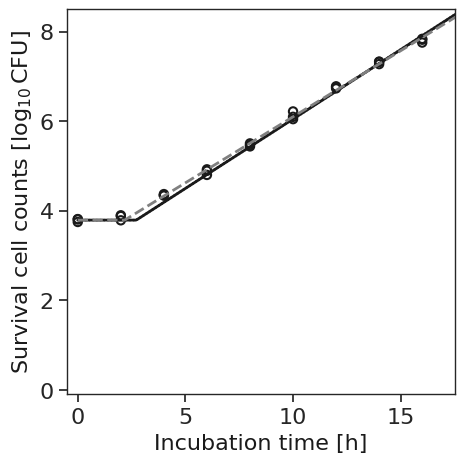

In [17]:
#graph
url = "https://raw.githubusercontent.com/Satoko-Hiura/Bayesian-generalized-linear-model-for-simulating-bacterial-inactivation-growth/main/code/growth/data/bayesian_fitting.csv"
data2 = pd.read_csv(url, encoding='utf-8')
TIME = data2['TIME']
N1 = data2['Nt']
N_new = N1 *(10 ** data2['Dilution'])
data2['N_new'] = N_new
fig = plt.figure()
plt.style.use('ggplot')
sns.set_style(style='ticks')
plt.figure(figsize=(5,5))
plt.ylabel('Survival cell counts [$\log_{10}$CFU]',fontsize=16, color='k')
plt.xlabel('Incubation time [h]', fontsize=16, color='k')
plt.tick_params(labelsize=16, direction='out')
plt.xlim(-0.5,17.5)
plt.ylim(-0.1,8.5)
plt.xticks([0,5,10,15])
plt.scatter(TIME, np.log10(N_new), edgecolors ='k', facecolors='none', linewidths=1.5, label='Kinetic (Conventional)')
plt.plot(T2,y_pred_500, linestyle = 'solid', zorder=1, color='k', lw=2.0, label='Bayesian credible median') #bayesian
plt.plot(T2,y_pred_975, linestyle = ':', zorder=1, color='k', lw=1.0, label='95% credible median') #bayesian
plt.plot(T2,y_pred_025, linestyle = ':', zorder=1, color='k', lw=1.0) #bayesian
plt.plot(T,Y,color='gray',linestyle='dashed',lw=2,zorder=2) #frequentism

#Stochastic expression from the estimated Bayesian model

In [18]:
#time for prediction
T = []
for i in range(211):
    t = i * 0.05
    T.append(t)

##Estimation from the estimated Bayesian model
### Used data and Bayesian prediction
**Credible interval**: The variated interval of the estimated curve lines  
**Predicted interval**: The variated interval of the estimated survival counts.   
Initial counts: 0.3, 2, 24 CFU


In [19]:
N0_mean = 0.3 #initial cell number(average)

#prediction interval
y_pred_int = np.zeros((len(mu),len(T)))
for i in range(len(mu)):
    N0 = np.random.poisson(N0_mean)
    for j in range(len(T)):
        if N0 == 0:
            y_pred_int[i,j] = 0
        elif  0 <= N0/(N0*math.exp(mu[i]*(T[j]-lag[i]))) <= 1:
            y_pred_int[i,j] = N0 + np.random.negative_binomial(N0, N0/(N0*math.exp(mu[i]*(T[j]-lag[i]))), size=1)
        else:
            y_pred_int[i,j] = N0

y_pred_upper0 = y_pred_int[y_pred_int[:,0] != 0]
y_pred_upper0_975 = np.percentile(y_pred_upper0, 2.5, axis=0)
y_pred_upper0_025 = np.percentile(y_pred_upper0, 97.5, axis=0)
y_pred_upper0_500 = np.percentile(y_pred_upper0, 50.0, axis=0)
y_pred = np.log10(y_pred_upper0)
y_pred_975 = np.percentile(y_pred, 2.5, axis=0)
y_pred_025 = np.percentile(y_pred, 97.5, axis=0)
y_pred_500 = np.percentile(y_pred, 50.0, axis=0)

#credible interval
y_cred_int = np.zeros((len(mu),len(T)))
for i in range(len(mu)):
    N0 = N0_mean
    for j in range(len(T)):
        if N0 == 0:
            y_cred_int[i,j] = 0
        elif  0 <= N0/(N0*math.exp(mu[i]*(T[j]-lag[i]))) <= 1:
            y_cred_int[i,j] = N0*(math.exp(mu[i]*(T[j]-lag[i])))
        else:
            y_cred_int[i,j] = N0

y_cred_upper0 = y_cred_int[y_cred_int[:,0] != 0]
y_cred_upper0_975 = np.percentile(y_cred_upper0, 2.5, axis=0)
y_cred_upper0_025 = np.percentile(y_cred_upper0, 97.5, axis=0)
y_cred_upper0_500 = np.percentile(y_cred_upper0, 50.0, axis=0)
y_cred = np.log10(y_cred_upper0)
y_cred_975 = np.percentile(y_cred, 2.5, axis=0)
y_cred_025 = np.percentile(y_cred, 97.5, axis=0)
y_cred_500 = np.percentile(y_cred, 50.0, axis=0)

In [20]:
# data import
url = "https://raw.githubusercontent.com/Satoko-Hiura/Bayesian-generalized-linear-model-for-simulating-bacterial-inactivation-growth/main/code/growth/data/0.3cell.csv"
data = pd.read_csv(url, encoding='utf-8')
time = data['TIME']
N = data['Nt']
N_new = N *(10 ** data['Dilution'])
data['N_new'] = N_new

Calculation of the the ratio of the point included in the predicted interval

In [21]:
#accuracy
Time = [0,2,4,6,8,10]
i = [0,1,2,3,4,5]
num = [50,50,50,50,50,49] #number of data
evaluation =[]
ZERO = []
for t,i in zip(Time,i):
    T1 = int(t/0.05)
    y_pred_min = y_pred_upper0_975[T1]
    y_pred_max = y_pred_upper0_025[T1]
    hani =[]
    repetition = num[i]
    for j in range(repetition):
        number = sum(num[0:i])+j
        N = N_new[number]
        if N == 0:
            ans = 2
        elif y_pred_min <= N <= y_pred_max :    
            ans= 1
        else:
            ans=0
        hani.append(ans)
    correct =hani.count(1)
    zero = hani.count(2)
    ZERO.append(zero)
    evaluation.append(correct)
accuracy = (sum(evaluation)/((sum(num)-sum(ZERO))))*100
print('Interval including ratio: '+str(accuracy))

Interval including ratio: 96.0


Visualization

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 640x480 with 0 Axes>

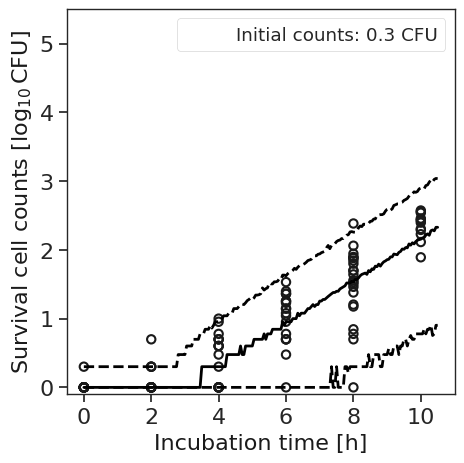

In [22]:
#graph
fig = plt.figure()
plt.style.use('ggplot')
sns.set_style(style='ticks')
plt.figure(figsize=(5,5))
plt.ylabel('Survival cell counts [$\log_{10}$CFU]',fontsize=16, color='k')
plt.xlabel('Incubation time [h]', fontsize=16, color='k')
plt.tick_params(labelsize=16, direction='out')
plt.xlim(-0.5,11)
plt.ylim(-0.1,5.5)
plt.xticks([0,2,4,6,8,10])
plt.scatter(time, np.log10(N_new), zorder=2, facecolors ='none',edgecolors='k',linewidth=1.5)

#prediction interval
plt.plot(T,y_pred_025, linestyle = 'dashed', zorder=2, color='black', lw=2.0)
plt.plot(T,y_pred_975, linestyle = 'dashed', zorder=2, color='black', lw=2.0, label='95% prediction band')
plt.plot(T,y_pred_500, linestyle = 'solid', zorder=2, color='black', lw=2.0, label='Median')
plt.legend(["Initial counts: 0.3 CFU"], markerscale=0)
plt.show()

In [23]:
N0_mean = 2 #initial cell number(average)

#prediction interval
y_pred_int = np.zeros((len(mu),len(T)))
for i in range(len(mu)):
    N0 = np.random.poisson(N0_mean)
    for j in range(len(T)):
        if N0 == 0:
            y_pred_int[i,j] = 0
        elif  0 <= N0/(N0*math.exp(mu[i]*(T[j]-lag[i]))) <= 1:
            y_pred_int[i,j] = N0 + np.random.negative_binomial(N0, N0/(N0*math.exp(mu[i]*(T[j]-lag[i]))), size=1)
        else:
            y_pred_int[i,j] = N0

y_pred_upper0 = y_pred_int[y_pred_int[:,0] != 0]
y_pred_upper0_975 = np.percentile(y_pred_upper0, 2.5, axis=0)
y_pred_upper0_025 = np.percentile(y_pred_upper0, 97.5, axis=0)
y_pred_upper0_500 = np.percentile(y_pred_upper0, 50.0, axis=0)
y_pred = np.log10(y_pred_upper0)
y_pred_975 = np.percentile(y_pred, 2.5, axis=0)
y_pred_025 = np.percentile(y_pred, 97.5, axis=0)
y_pred_500 = np.percentile(y_pred, 50.0, axis=0)

#credible interval
y_cred_int = np.zeros((len(mu),len(T)))
for i in range(len(mu)):
    N0 = N0_mean
    for j in range(len(T)):
        if N0 == 0:
            y_cred_int[i,j] = 0
        elif  0 <= N0/(N0*math.exp(mu[i]*(T[j]-lag[i]))) <= 1:
            y_cred_int[i,j] = N0*(math.exp(mu[i]*(T[j]-lag[i])))
        else:
            y_cred_int[i,j] = N0

y_cred_upper0 = y_cred_int[y_cred_int[:,0] != 0]
y_cred_upper0_975 = np.percentile(y_cred_upper0, 2.5, axis=0)
y_cred_upper0_025 = np.percentile(y_cred_upper0, 97.5, axis=0)
y_cred_upper0_500 = np.percentile(y_cred_upper0, 50.0, axis=0)
y_cred = np.log10(y_cred_upper0)
y_cred_975 = np.percentile(y_cred, 2.5, axis=0)
y_cred_025 = np.percentile(y_cred, 97.5, axis=0)
y_cred_500 = np.percentile(y_cred, 50.0, axis=0)

In [24]:
# data import
url = "https://raw.githubusercontent.com/Satoko-Hiura/Bayesian-generalized-linear-model-for-simulating-bacterial-inactivation-growth/main/code/growth/data/2cell.csv"
data = pd.read_csv(url, encoding='utf-8')
time = data['TIME']
N = data['Nt']
N_new = N *(10 ** data['Dilution'])
data['N_new'] = N_new

Calculation of the the ratio of the point included in the predicted interval

In [25]:
#accuracy
Time = [0,2,4,6,8,10]
i = [0,1,2,3,4,5]
num = [50,50,50,50,50,49] #number of data
evaluation =[]
ZERO = []
for t,i in zip(Time,i):
    T1 = int(t/0.05)
    y_pred_min = y_pred_upper0_975[T1]
    y_pred_max = y_pred_upper0_025[T1]
    hani =[]
    repetition = num[i]
    for j in range(repetition):
        number = sum(num[0:i])+j
        N = N_new[number]
        if N == 0:
            ans = 2
        elif y_pred_min <= N <= y_pred_max :    
            ans= 1
        else:
            ans=0
        hani.append(ans)
    correct =hani.count(1)
    zero = hani.count(2)
    ZERO.append(zero)
    evaluation.append(correct)
accuracy = (sum(evaluation)/((sum(num)-sum(ZERO))))*100
print('Interval including ratio: '+str(accuracy))

Interval including ratio: 93.18181818181817


Visualization

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 640x480 with 0 Axes>

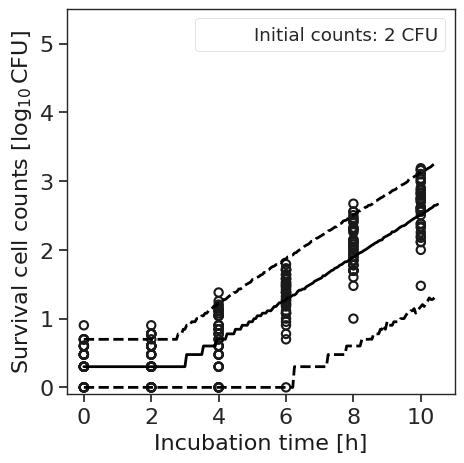

In [26]:
#graph
fig = plt.figure()
plt.style.use('ggplot')
sns.set_style(style='ticks')
plt.figure(figsize=(5,5))
plt.ylabel('Survival cell counts [$\log_{10}$CFU]',fontsize=16, color='k')
plt.xlabel('Incubation time [h]', fontsize=16, color='k')
plt.tick_params(labelsize=16, direction='out')
plt.xlim(-0.5,11)
plt.ylim(-0.1,5.5)
plt.xticks([0,2,4,6,8,10])
plt.scatter(time, np.log10(N_new), zorder=2, facecolors ='none',edgecolors='k',linewidth=1.5)

#prediction interval
plt.plot(T,y_pred_025, linestyle = 'dashed', zorder=2, color='black', lw=2.0)
plt.plot(T,y_pred_975, linestyle = 'dashed', zorder=2, color='black', lw=2.0, label='95% prediction band')
plt.plot(T,y_pred_500, linestyle = 'solid', zorder=2, color='black', lw=2.0, label='Median')
plt.legend(["Initial counts: 2 CFU"], markerscale=0)
plt.show()

In [27]:
N0_mean = 24 #initial cell number(average)

#prediction interval
y_pred_int = np.zeros((len(mu),len(T)))
for i in range(len(mu)):
    N0 = np.random.poisson(N0_mean)
    for j in range(len(T)):
        if N0 == 0:
            y_pred_int[i,j] = 0
        elif  0 <= N0/(N0*math.exp(mu[i]*(T[j]-lag[i]))) <= 1:
            y_pred_int[i,j] = N0 + np.random.negative_binomial(N0, N0/(N0*math.exp(mu[i]*(T[j]-lag[i]))), size=1)
        else:
            y_pred_int[i,j] = N0

y_pred_upper0 = y_pred_int[y_pred_int[:,0] != 0]
y_pred_upper0_975 = np.percentile(y_pred_upper0, 2.5, axis=0)
y_pred_upper0_025 = np.percentile(y_pred_upper0, 97.5, axis=0)
y_pred_upper0_500 = np.percentile(y_pred_upper0, 50.0, axis=0)
y_pred = np.log10(y_pred_upper0)
y_pred_975 = np.percentile(y_pred, 2.5, axis=0)
y_pred_025 = np.percentile(y_pred, 97.5, axis=0)
y_pred_500 = np.percentile(y_pred, 50.0, axis=0)

#credible interval
y_cred_int = np.zeros((len(mu),len(T)))
for i in range(len(mu)):
    N0 = N0_mean
    for j in range(len(T)):
        if N0 == 0:
            y_cred_int[i,j] = 0
        elif  0 <= N0/(N0*math.exp(mu[i]*(T[j]-lag[i]))) <= 1:
            y_cred_int[i,j] = N0*(math.exp(mu[i]*(T[j]-lag[i])))
        else:
            y_cred_int[i,j] = N0

y_cred_upper0 = y_cred_int[y_cred_int[:,0] != 0]
y_cred_upper0_975 = np.percentile(y_cred_upper0, 2.5, axis=0)
y_cred_upper0_025 = np.percentile(y_cred_upper0, 97.5, axis=0)
y_cred_upper0_500 = np.percentile(y_cred_upper0, 50.0, axis=0)
y_cred = np.log10(y_cred_upper0)
y_cred_975 = np.percentile(y_cred, 2.5, axis=0)
y_cred_025 = np.percentile(y_cred, 97.5, axis=0)
y_cred_500 = np.percentile(y_cred, 50.0, axis=0)

In [28]:
# data import
url = "https://raw.githubusercontent.com/Satoko-Hiura/Bayesian-generalized-linear-model-for-simulating-bacterial-inactivation-growth/main/code/growth/data/24cell.csv"
data = pd.read_csv(url, encoding='utf-8')
time = data['TIME']
N = data['Nt']
N_new = N *(10 ** data['Dilution'])
data['N_new'] = N_new

Calculation of the the ratio of the point included in the predicted interval

In [29]:
#accuracy
Time = [0,2,4,6,8,10] #time for prediction (h)
i = [0,1,2,3,4,5]
num = [50,50,50,50,48,50] #number of data
evaluation =[]
ZERO = []
for t,i in zip(Time,i):
    T1 = int(t/0.05)
    y_pred_min = y_pred_upper0_975[T1]
    y_pred_max = y_pred_upper0_025[T1]
    hani =[]
    repetition = num[i]
    for j in range(repetition):
        number = sum(num[0:i])+j
        N = N_new[number]
        if N == 0:
            ans = 2
        elif y_pred_min <= N <= y_pred_max :    
            ans= 1
        else:
            ans=0
        hani.append(ans)
    correct =hani.count(1)
    zero = hani.count(2)
    ZERO.append(zero)
    evaluation.append(correct)
accuracy = (sum(evaluation)/(sum(num)-sum(ZERO)))*100
print('Interval including ratio: '+str(accuracy))

Interval including ratio: 79.53020134228188


Visualization

<Figure size 640x480 with 0 Axes>

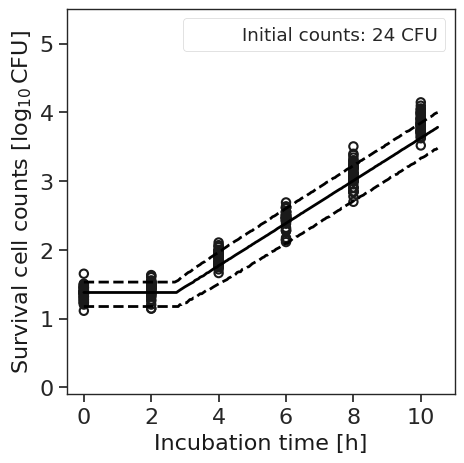

In [30]:
#graph
fig = plt.figure()
plt.style.use('ggplot')
sns.set_style(style='ticks')
plt.figure(figsize=(5,5))
plt.ylabel('Survival cell counts [$\log_{10}$CFU]',fontsize=16, color='k')
plt.xlabel('Incubation time [h]', fontsize=16, color='k')
plt.tick_params(labelsize=16, direction='out')
plt.xlim(-0.5,11)
plt.ylim(-0.1,5.5)
plt.xticks([0,2,4,6,8,10])
plt.scatter(time, np.log10(N_new), zorder=2, facecolors ='none',edgecolors='k',linewidth=1.5)

#prediction interval
plt.plot(T,y_pred_025, linestyle = 'dashed', zorder=2, color='black', lw=2.0)
plt.plot(T,y_pred_975, linestyle = 'dashed', zorder=2, color='black', lw=2.0, label='95% prediction band')
plt.plot(T,y_pred_500, linestyle = 'solid', zorder=2, color='black', lw=2.0, label='Median')
plt.legend(["Initial counts: 24 CFU"], markerscale=0)
plt.show()